In [2]:
# importing necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import keras
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# reading the dataset
df= pd.read_csv('age_gender.csv')
print(df.head())


   age  ethnicity  gender                        img_name   
0    1          2       0  20161219203650636.jpg.chip.jpg  \
1    1          2       0  20161219222752047.jpg.chip.jpg   
2    1          2       0  20161219222832191.jpg.chip.jpg   
3    1          2       0  20161220144911423.jpg.chip.jpg   
4    1          2       0  20161220144914327.jpg.chip.jpg   

                                              pixels  
0  129 128 128 126 127 130 133 135 139 142 145 14...  
1  164 74 111 168 169 171 175 182 184 188 193 199...  
2  67 70 71 70 69 67 70 79 90 103 116 132 145 155...  
3  193 197 198 200 199 200 202 203 204 205 208 21...  
4  202 205 209 210 209 209 210 211 212 214 218 21...  


In [4]:
# information about the dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


# Check the input Face images: To visualize an Image, we are first generating a list of random indices value from the dataset and using that to plot a subplot of images. To plot the image we have to first reshape the data into a (48,48,1) shape.


KeyError: 'new_pixels'

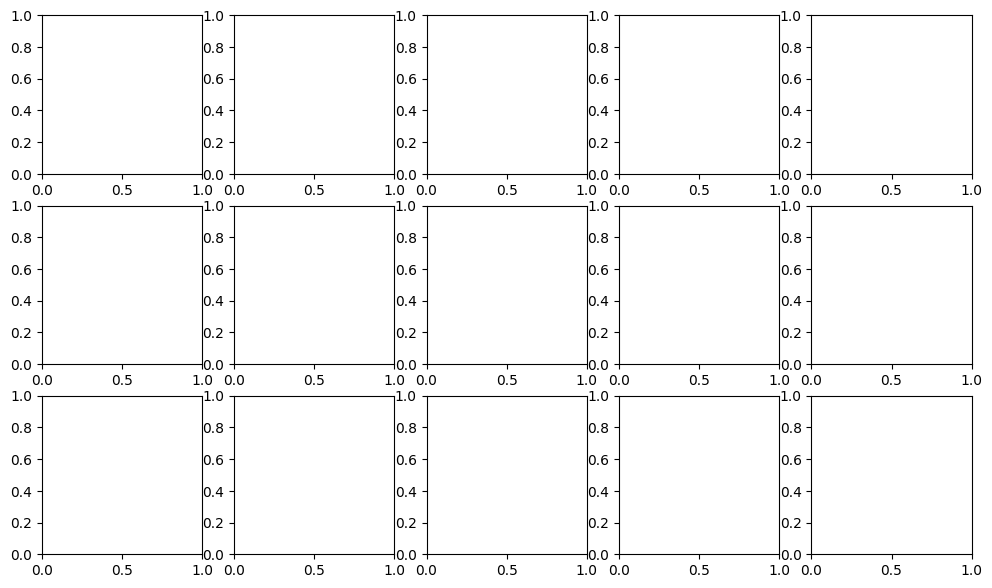

In [9]:
# creating an empty 3x3 subplot
fig, ax = plt.subplots(3, 5, figsize=(12, 7))
ax = ax.ravel()

# generating a random list of integers
res = random.sample(range(0, df.shape[0]), 15)

# creating the subplot for random images and printing the corresponding gender and age
for i, id in enumerate(res):
	ax[i].imshow(df['new_pixels'].loc[id].reshape(48, 48))
	ax[i].set_title(f'Age:{df.age.loc[id]}, Gender:{df.gender.loc[id]}')
	ax[i].axis('off')
plt.savefig('image_visualization_subplot.png')


# Model Building
## To start with creating the model, we first expand the new pixels column to make a dataframe. Using that dataframe and necessary target values (age and gender), we will split our dataset into training and Validation Dataset.

In [ ]:
# create the X (predictor) variables
X_new = pd.DataFrame(df['new_pixels'].tolist())

# Assign Predictor Variables and Target variables
X = X_new
y_age = df['age'].values
y_gender = df['gender'].values

# split the Variables into Train and Validation sets
y_reg_train, y_reg_val, y_clf_train, y_clf_val, X_train, X_val = train_test_split(
    y_age,
    y_gender,
    X,
    test_size=0.2,
    stratify = y_gender,
    random_state=42
)
# Check the shape
y_reg_train.shape, y_reg_val.shape, y_clf_train.shape, y_clf_val.shape, X_train.shape, X_val.shape


((18964,), (4741,), (18964,), (4741,), (18964, 2304), (4741, 2304))

# Normalizations
# Before we proceed forward, a necessary step in Data preparation for training is to normalize the pixel data. This ensures that the pixels are in a similar data distribution which will help in faster model convergence in training.

In [ ]:
# normalising the Pixel data for training dataset and then reshaping it to (48,48,1) 
Xmin = 0
Xmax = 255
X_train = X_train.values
X_train = X_train - Xmin/(Xmax-Xmin)
X_train = X_train.reshape(-1,48,48,1)

# similar step is taken for Validation set
X_val = X_val.values
X_val = X_val - Xmin/(Xmax-Xmin)
X_val = X_val.reshape(-1,48,48,1)


# Creating The CNN model Architecture
# The model architecture is made using functional API of keras. This method is helpful in joining two types of output (in this case regression and classification) as a single output to be fed to the model.

# The Model takes 3 parts:

# Input: This layer takes in the input data with shape (48,48,1)
# Middle architecture: All the Deep Learning Networks are cascaded over Input layer, i.e., the input layer is joined with subsequent layers in the deep learning model. In this case the architecture consists of:
# a single Conv2D layer with 16 node
# a single Conv2D layer with 32 nodes followed by Maxpooling2D layer
# two conv2D layer with 64 nodes each
# a flatten layer
# two dense layer of 128 and 32 nodes respectively.

# Output: The output of the model consist of two dense layers which corresponds to the necessary task they will perform which are:
# a dense layer with 1 node and sigmoid activation which will perform the gender classification
# a dense layer with 1 node and linear activation which will perform the age regression prediction
# For all the other layers, necessary activations were provided. To understand the underlying layers and the parameters involved in the model architecture created above, we will plot the model

In [ ]:
input_layer = keras.Input(shape=(48, 48, 1), name="Input image")
x = layers.Conv2D(16, 3, activation="relu")(input_layer)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)



out_a = keras.layers.Dense(1, activation='sigmoid', name='g_clf')(x)
out_b = keras.layers.Dense(1, activation='linear', name='a_reg')(x)

model = keras.Model( inputs = input_layer, outputs = [out_a, out_b], name="age_gender_model")


# Model Training
# We compile the model with necessary loss, metrics and optimizers and fitted the model for 200 epochs with an earlystopping of patience 25.

In [ ]:
# compile the model
model.compile(
	loss = {
		"g_clf": 'binary_crossentropy',
		"a_reg": 'mse'
	},

	metrics = {
		"g_clf": 'accuracy',
		"a_reg": 'mse'
	},

	optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
)

# create an EarlyStopping instance which will stop if the val_loss doesn't change much in 25 epochs
callback = EarlyStopping(monitor='val_loss',
						patience=25,
						verbose=0)

# train the model 
history = model.fit(X_train, 
					[y_clf_train, y_reg_train],
					batch_size = 256, 
					validation_data= (X_val, [y_clf_val, y_reg_val]), 
					epochs=200, callbacks = [callback])


Epoch 1/200
75/75 [==============================] - 54s 696ms/step - loss: 13791.9160 - g_clf_loss: 2.6200 - a_reg_loss: 13789.2988 - g_clf_accuracy: 0.5059 - a_reg_mse: 13789.2988 - val_loss: 387.6367 - val_g_clf_loss: 0.6974 - val_a_reg_loss: 386.9394 - val_g_clf_accuracy: 0.5596 - val_a_reg_mse: 386.9394
Epoch 2/200
75/75 [==============================] - 40s 533ms/step - loss: 333.0539 - g_clf_loss: 0.7250 - a_reg_loss: 332.3288 - g_clf_accuracy: 0.6120 - a_reg_mse: 332.3288 - val_loss: 296.5009 - val_g_clf_loss: 0.6795 - val_a_reg_loss: 295.8214 - val_g_clf_accuracy: 0.6383 - val_a_reg_mse: 295.8214
Epoch 3/200
75/75 [==============================] - 20s 271ms/step - loss: 242.8613 - g_clf_loss: 0.6288 - a_reg_loss: 242.2326 - g_clf_accuracy: 0.6736 - a_reg_mse: 242.2326 - val_loss: 308.7493 - val_g_clf_loss: 0.6313 - val_a_reg_loss: 308.1181 - val_g_clf_accuracy: 0.6866 - val_a_reg_mse: 308.1181
Epoch 4/200
75/75 [==============================] - 39s 519ms/step - loss: 237.82

# Plotting the Losses and Accuracy for Regression and Classification Respectively
# To visualize the losses, we will use history of our model training and plot the necessary metrices.

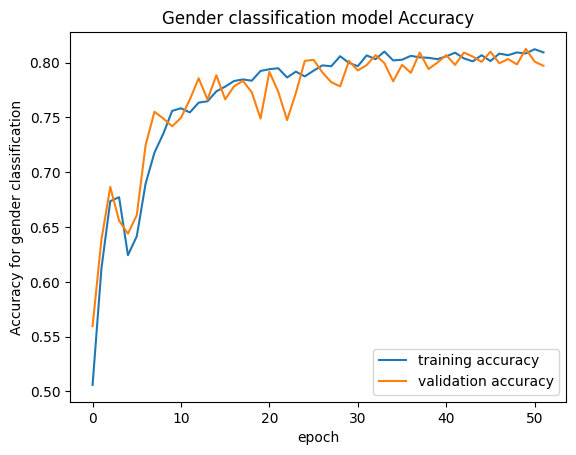

In [ ]:
# plotting for Gender Classification Accuracy
plt.plot(history.history['g_clf_accuracy'], label = 'training accuracy')
plt.plot(history.history['val_g_clf_accuracy'], label = 'validation accuracy')
plt.title('Gender classification model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy for gender classification')
plt.legend()
plt.show()


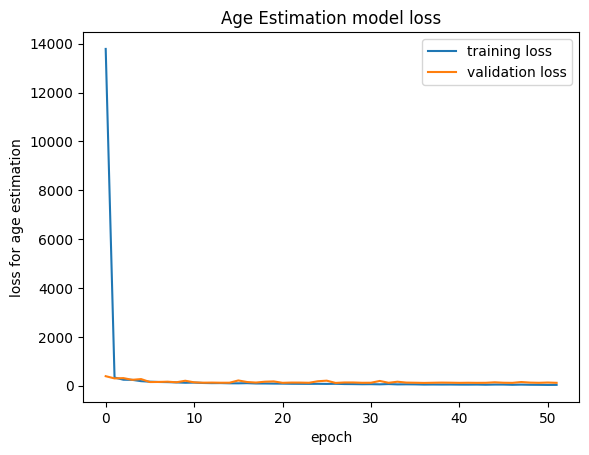

In [ ]:
# plotting the mse loss for age regression 
plt.plot(history.history['a_reg_mse'], label = 'training loss')
plt.plot(history.history['val_a_reg_mse'], label = 'validation loss')
plt.title('Age Estimation model loss')
plt.xlabel('epoch')
plt.ylabel('loss for age estimation')
plt.legend()

plt.show()


# Evaluation 


In [ ]:
model.evaluate(X_val, [y_clf_val, y_reg_val])


149/149 [==============================] - 1s 10ms/step - loss: 115.8917 - g_clf_loss: 0.4498 - a_reg_loss: 115.4419 - g_clf_accuracy: 0.7971 - a_reg_mse: 115.4419


[115.89169311523438,
 0.4498210847377777,
 115.44187927246094,
 0.7970892190933228,
 115.44187927246094]

# Predictn Age & Gender from the model
# We created a subplot of 3×3 with random indices and predicted the age and gender for the given input image

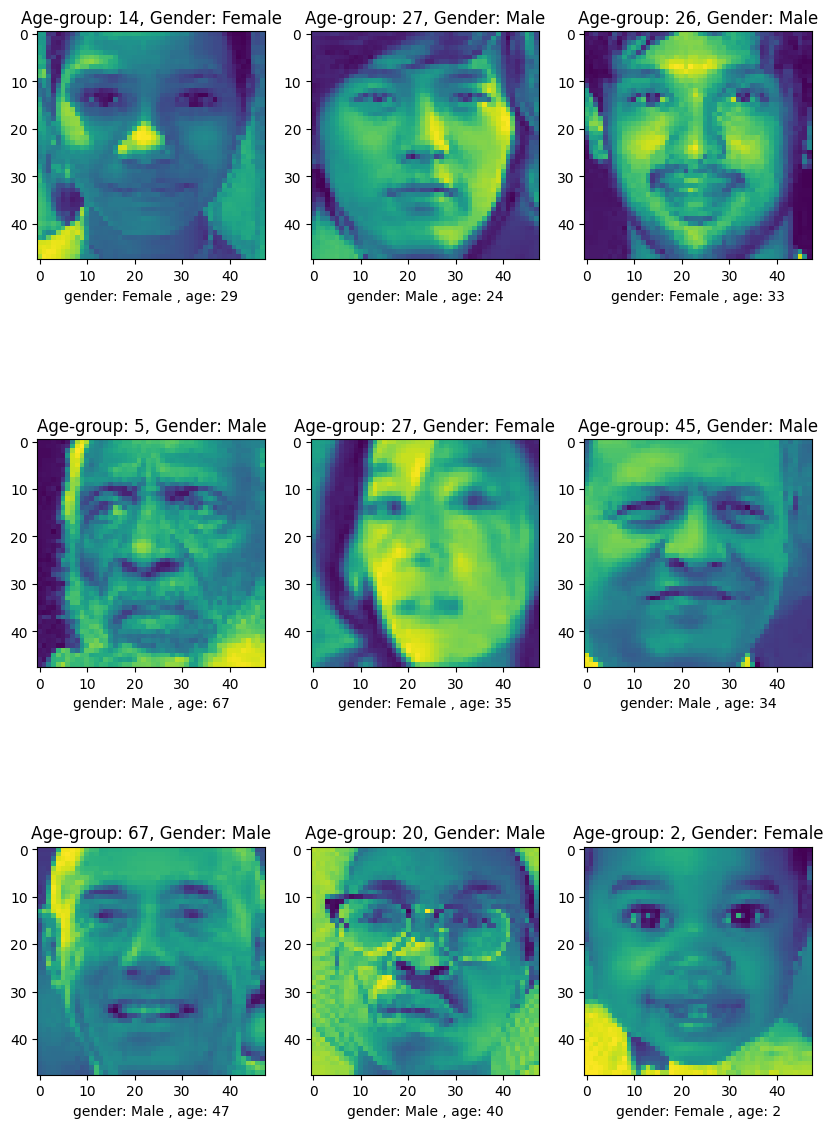

In [ ]:
fig, ax = plt.subplots(3,3, figsize = (10,15))

ax = ax.ravel()

res = random.sample(range(0, X_val.shape[0]), 9)
# Define gender_dict mapping gender labels to categories
gender_dict = {'0': 'Male', '1': 'Female'}


for i,id in enumerate(res):
	ax[i].imshow(X_val[id])
	ax[i].set_title(f'Age-group: {y_reg_val[id]}, Gender: {gender_dict[str(y_clf_val[id])]}')
	
	pred_Gender, pred_age = model.predict(tf.expand_dims(X_val[id], 0), verbose = 0)
	y_value = np.where(pred_Gender > 0.5, 1,0)
	ax[i].set_xlabel(f'gender: {gender_dict[str(y_value[0][0])]} , age: {int(np.round(pred_age,0))}')
	
plt.savefig('prediction_subplot.png')
